In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(torch.cuda.get_device_name(0))
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

NVIDIA GeForce RTX 2080 SUPER


# Load FashionMNIST Data

In [3]:
fashion_train = datasets.FashionMNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

fashion_test = datasets.FashionMNIST(root='data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [4]:
batch_size = 128
train_loader  = torch.utils.data.DataLoader(dataset=fashion_train,
                                           batch_size=batch_size,
                                           shuffle=False)

test_batch_size = 32
test_loader = torch.utils.data.DataLoader(dataset=fashion_test,
                                         batch_size=test_batch_size,
                                         shuffle=False)

In [5]:
train_loader.dataset[0][0].shape

torch.Size([1, 28, 28])

# Train Base Model

In [5]:
from models import Net, get_resnet18_MNIST

# ResNet18 for MNIST & FashionMNIST
model = get_resnet18_MNIST().cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
from attacks import fgsm_attack

num_epochs = 50

for epoch in range(num_epochs):

    total_batch = len(fashion_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        # batch_perturbations = fgsm_attack(batch_images, batch_labels).cuda()

        X = batch_images.cuda()
        Y = batch_labels.cuda()

        outputs = model(X)
        loss = criterion(outputs, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [%d/%d], Loss: %.4f'
        %(epoch+1, num_epochs, loss.item()))

Epoch [1/50], Loss: 0.2518
Epoch [2/50], Loss: 0.1833
Epoch [3/50], Loss: 0.1831
Epoch [4/50], Loss: 0.1294
Epoch [5/50], Loss: 0.1087
Epoch [6/50], Loss: 0.1345
Epoch [7/50], Loss: 0.1153
Epoch [8/50], Loss: 0.1463
Epoch [9/50], Loss: 0.0859
Epoch [10/50], Loss: 0.0710
Epoch [11/50], Loss: 0.0500
Epoch [12/50], Loss: 0.0566
Epoch [13/50], Loss: 0.0261
Epoch [14/50], Loss: 0.0791
Epoch [15/50], Loss: 0.0464
Epoch [16/50], Loss: 0.0615
Epoch [17/50], Loss: 0.0223
Epoch [18/50], Loss: 0.0297
Epoch [19/50], Loss: 0.0462
Epoch [20/50], Loss: 0.0075
Epoch [21/50], Loss: 0.0149
Epoch [22/50], Loss: 0.0215
Epoch [23/50], Loss: 0.0463
Epoch [24/50], Loss: 0.0113
Epoch [25/50], Loss: 0.0074
Epoch [26/50], Loss: 0.0009
Epoch [27/50], Loss: 0.0127
Epoch [28/50], Loss: 0.0048
Epoch [29/50], Loss: 0.0478
Epoch [30/50], Loss: 0.0009
Epoch [31/50], Loss: 0.0104
Epoch [32/50], Loss: 0.0077
Epoch [33/50], Loss: 0.0387
Epoch [34/50], Loss: 0.0042
Epoch [35/50], Loss: 0.0058
Epoch [36/50], Loss: 0.0065
E

In [33]:
torch.save(model.state_dict(), 'models/FashionMNIST_ResNet18.pth')

### Load Model

In [7]:
from models import Net, get_resnet18_MNIST

model = get_resnet18_MNIST().cuda()
model.load_state_dict(torch.load('models/FashionMNIST_ResNet18.pth'))

<All keys matched successfully>

## Standard Testing

In [8]:
correct = 0
total = 0

with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)

        outputs = model(data)

        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Accuracy {100 * correct // total} %')

Accuracy 90 %


# Adversarial Attack - Robust Accuracy

In [12]:
from attacks import fgsm_attack
import importlib
import sys
importlib.reload(sys.modules['attacks'])
from attacks import test_robustness

# eps = 0 means no attack
epsilons = [0, .05, .1, .15, .2, .25, .3]
# epsilons = [0, 0.05]

# accuracies of each eps test
accuracies = []

# resulting adversarial examples
examples = []

# generated perturbations
perturbations = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex, adv_per = test_robustness(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)
    perturbations.append(adv_per)

Epsilon: 0	Test Accuracy = 9009 / 10000 = 0.9009
Epsilon: 0.05	Test Accuracy = 5086 / 10000 = 0.5086
Epsilon: 0.1	Test Accuracy = 3878 / 10000 = 0.3878
Epsilon: 0.15	Test Accuracy = 3209 / 10000 = 0.3209
Epsilon: 0.2	Test Accuracy = 2838 / 10000 = 0.2838
Epsilon: 0.25	Test Accuracy = 2605 / 10000 = 0.2605
Epsilon: 0.3	Test Accuracy = 2402 / 10000 = 0.2402


## Visualizaing Learned Perturbations 

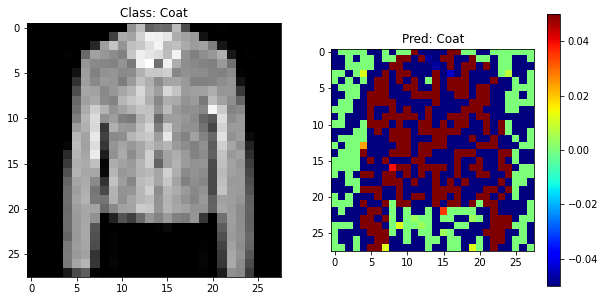

In [13]:
e = 1
i = 10
# original_img = examples[e][i][3][0][0].squeeze().detach().cpu().numpy()
original_img = examples[e][i][3][0]
adv_img = examples[e][i][2][0]

diff = original_img - adv_img
# diff = torch.cdist(original_img, adv_img, p = 2)
# diff = (diff - diff.min()) / (diff.max() - diff.min())
diff = diff.squeeze().detach().cpu().numpy()
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(original_img.squeeze().detach().cpu().numpy(), cmap='gray')
plt.title(f"Class: {fashion_train.classes[examples[0][i][0]]}")

plt.subplot(1, 2, 2)
plt.imshow(diff, cmap='jet')
plt.title(f"Pred: {fashion_train.classes[examples[e][i][1]]}")
plt.colorbar()
plt.show()

In [14]:
diff[0][0:3], original_img[0][0:3], adv_img[0][0:3]

(array([-0.05,  0.  ,  0.  ], dtype=float32),
 tensor([0., 0., 0.], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([0.0500, 0.0000, 0.0000], device='cuda:0', grad_fn=<SliceBackward0>))

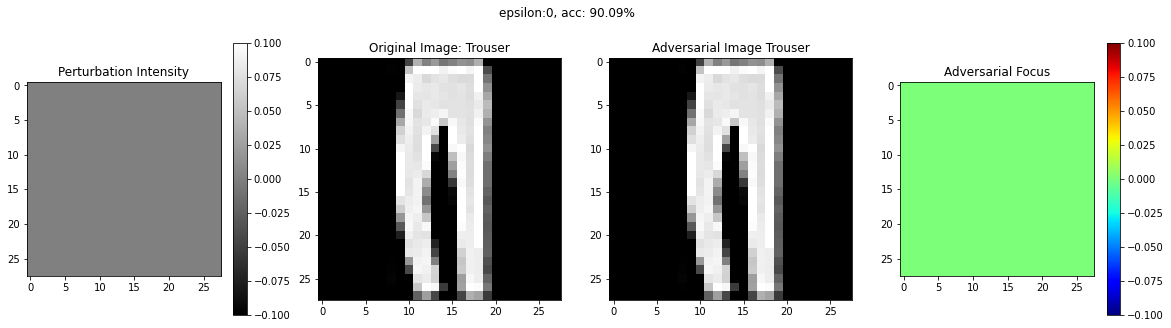

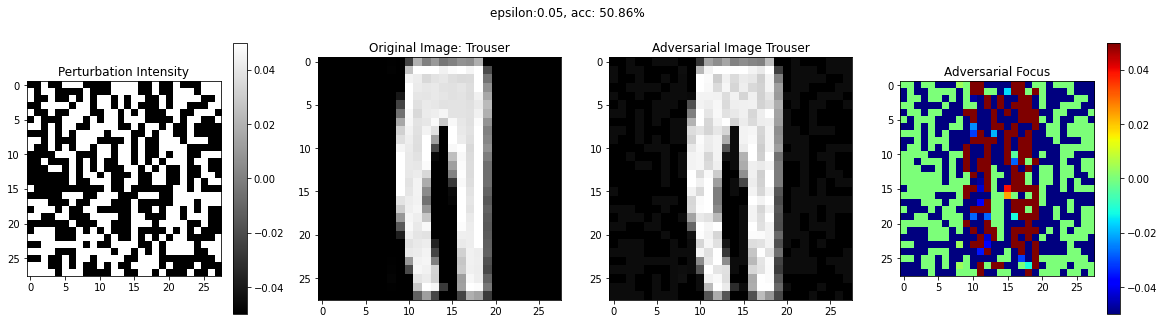

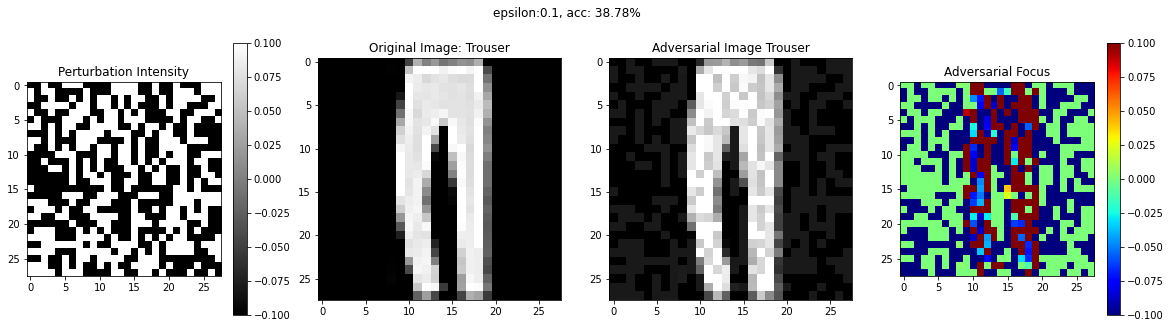

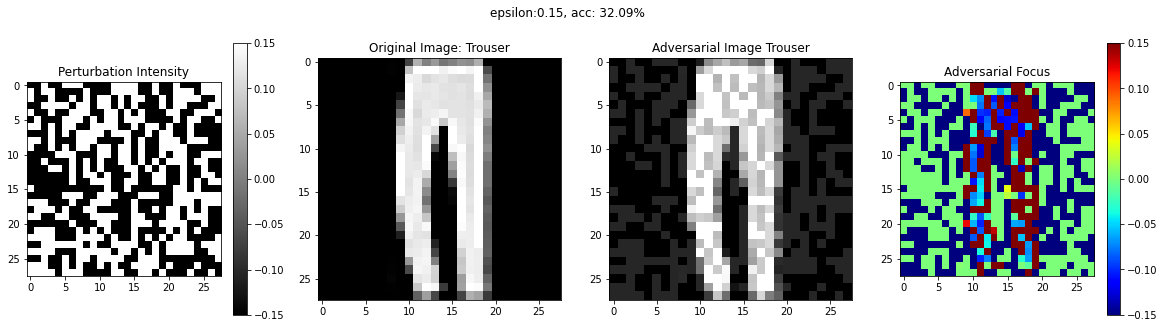

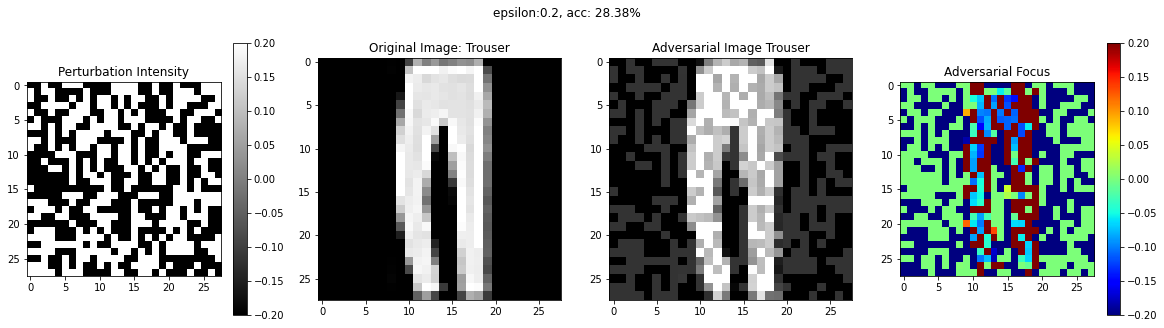

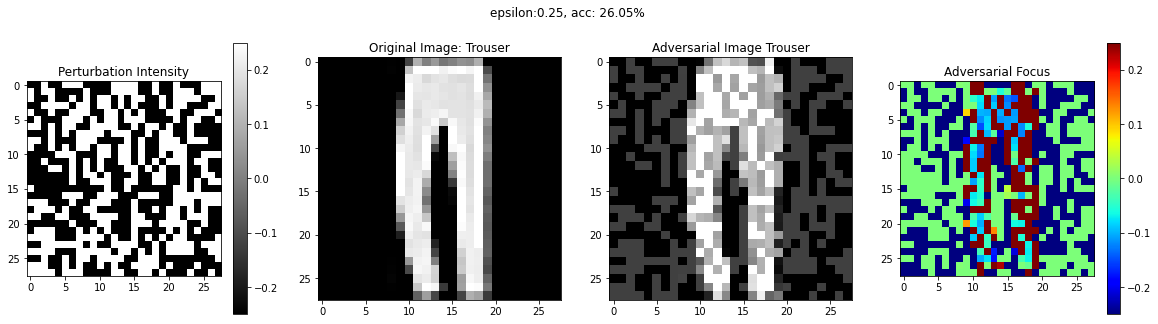

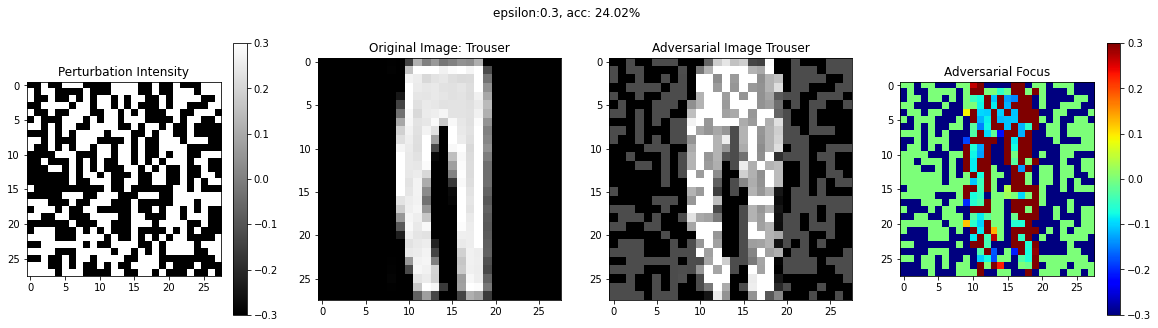

In [15]:
for e, e_value in enumerate(epsilons):
    # if e == 0: continue
    
    plt.figure(figsize = (20, 5))
    plt.suptitle(f"epsilon:{e_value}, acc: {np.round(accuracies[e] * 100, 4)}%")
    i = 2
    plt.subplot(1,4,1)
    p = perturbations[e][i][0].squeeze().detach().cpu().numpy()
    plt.imshow(p, cmap="gray")
    plt.title(f"Perturbation Intensity")
    plt.colorbar()

    plt.subplot(1,4,2)
    original_img = examples[e][i][3].squeeze().detach().cpu().numpy()
    plt.imshow(original_img, cmap="gray")
    plt.title(f"Original Image: {fashion_train.classes[examples[e][i][0]]}")


    plt.subplot(1,4,3)
    adv_img = examples[e][i][2].squeeze().detach().cpu().numpy()
    plt.imshow(adv_img, cmap="gray")
    plt.title(f"Adversarial Image {fashion_train.classes[examples[e][i][1]]}")

    plt.subplot(1,4, 4)
    diff = original_img - adv_img
    # MinMax Scaling [0,1]
    # diff = (diff - diff.min()) / (diff.max() - diff.min())
    plt.imshow(diff, cmap='jet')
    plt.colorbar()
    plt.title("Adversarial Focus")
    plt.show();


## Transfer Robustness via Adversarial Perturbations

In [17]:
mnist_train = datasets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = datasets.MNIST(root='data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [18]:
train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                         batch_size=test_batch_size,
                                         shuffle=False)

# MNIST Model

## NO Perturbation Added (Baseline)

In [19]:
# ResNet18 for MNIST
model_A = get_resnet18_MNIST().cuda()
criterion_A = nn.CrossEntropyLoss()
optimizer_A = optim.Adam(model_A.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    total_batch = len(mnist_train) // batch_size
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        outputs = model_A(X)
        loss = criterion_A(outputs, Y)

        optimizer_A.zero_grad()
        loss.backward()
        optimizer_A.step()

    print('Epoch [%d/%d], Loss: %.4f'
        %(epoch+1, num_epochs, loss.item()))

Epoch [1/10], Loss: 0.1372
Epoch [2/10], Loss: 0.1587
Epoch [3/10], Loss: 0.1388
Epoch [4/10], Loss: 0.1215
Epoch [5/10], Loss: 0.1128
Epoch [6/10], Loss: 0.1573
Epoch [7/10], Loss: 0.1325
Epoch [8/10], Loss: 0.1224
Epoch [9/10], Loss: 0.1127
Epoch [10/10], Loss: 0.1333


In [20]:
torch.save(model_A.state_dict(), 'models/MNIST_ResNet18_baseline.pth')

In [20]:
# eps = 0 means no attack
epsilons = [0, .05, .1, .15, .2, .25, .3]

# accuracies of each eps test
accuracies_A = []

# Run test for each epsilon
for eps in epsilons:
    acc, _, _ = test_robustness(model_A, device, test_loader, eps)
    accuracies_A.append(acc)

Epsilon: 0	Test Accuracy = 9829 / 10000 = 0.9829
Epsilon: 0.05	Test Accuracy = 9001 / 10000 = 0.9001
Epsilon: 0.1	Test Accuracy = 7344 / 10000 = 0.7344
Epsilon: 0.15	Test Accuracy = 5600 / 10000 = 0.56
Epsilon: 0.2	Test Accuracy = 4372 / 10000 = 0.4372
Epsilon: 0.25	Test Accuracy = 3567 / 10000 = 0.3567
Epsilon: 0.3	Test Accuracy = 3012 / 10000 = 0.3012


## With Perturbation Data Augmentation on Training (Our Proposal)

### Preproccess perturbation

In [21]:
# remove first batch of perturbation due to unexisting perturbation when EPS = 0
perturbations.pop(0);

In [22]:
len(epsilons)

7

In [23]:
# function to get a random perturbation give a eps size
def get_perturbation(perturbation_list, N, eps_index = 0):
    selected_p_index = np.random.randint(N)
    p = perturbation_list[eps_index][selected_p_index][0][0]
    # plt.imshow(p.squeeze().detach().cpu().numpy(), cmap='jet')
    # plt.colorbar()
    return p

### Train with Perturbations

In [24]:
# ResNet18 for MNIST
model_B = get_resnet18_MNIST().cuda()
criterion_B = nn.CrossEntropyLoss()
optimizer_B = optim.Adam(model_B.parameters(), lr=0.001)

N = 500 # number of pertubations set
num_epochs = 10

for epoch in range(num_epochs):
    total_batch = len(mnist_train) // batch_size
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        # eps_index is a hyperparameter
        p = get_perturbation(perturbations, N, eps_index = np.random.randint(len(epsilons) - 1))
        X = torch.add(X, p)

        outputs = model_B(X)
        loss = criterion_B(outputs, Y)

        optimizer_B.zero_grad()
        loss.backward()
        optimizer_B.step()

    print('Epoch [%d/%d], Loss: %.4f'
        %(epoch+1, num_epochs, loss.item()))

Epoch [1/10], Loss: 0.1423
Epoch [2/10], Loss: 0.1836
Epoch [3/10], Loss: 0.1378
Epoch [4/10], Loss: 0.1362
Epoch [5/10], Loss: 0.1385
Epoch [6/10], Loss: 0.1169
Epoch [7/10], Loss: 0.1315
Epoch [8/10], Loss: 0.1244
Epoch [9/10], Loss: 0.1209
Epoch [10/10], Loss: 0.1085


In [25]:
torch.save(model_B.state_dict(), 'models/MNIST_ResNet18_robust.pth')

In [37]:
# eps = 0 means no attack
epsilons = [0, .05, .1, .15, .2, .25, .3]

# accuracies of each eps test
accuracies_B = []

# resulting adversarial examples
examples_B = []

# generated perturbations
perturbations_B = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex, adv_per = test_robustness(model_B, device, test_loader, eps)
    accuracies_B.append(acc)
    examples_B.append(ex)
    perturbations_B.append(adv_per)

Epsilon: 0	Test Accuracy = 9837 / 10000 = 0.9837
Epsilon: 0.05	Test Accuracy = 9372 / 10000 = 0.9372
Epsilon: 0.1	Test Accuracy = 8376 / 10000 = 0.8376
Epsilon: 0.15	Test Accuracy = 6924 / 10000 = 0.6924
Epsilon: 0.2	Test Accuracy = 5568 / 10000 = 0.5568
Epsilon: 0.25	Test Accuracy = 4563 / 10000 = 0.4563
Epsilon: 0.3	Test Accuracy = 3792 / 10000 = 0.3792


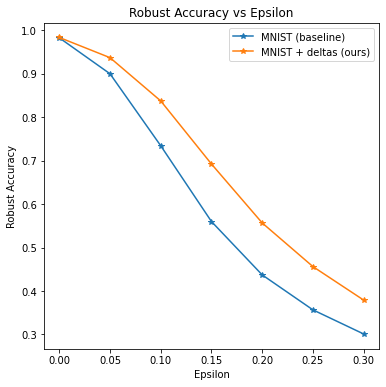

In [38]:
plt.figure(figsize=(6,6))
plt.plot(epsilons, accuracies_A, "*-", label = "MNIST (baseline)")
plt.plot(epsilons, accuracies_B, "*-", label = "MNIST + deltas (ours)")
plt.title("Robust Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Robust Accuracy")
plt.legend()
plt.show()

In [57]:
examples_B[0][2][0], examples_B[0][2][1]

(1, 1)

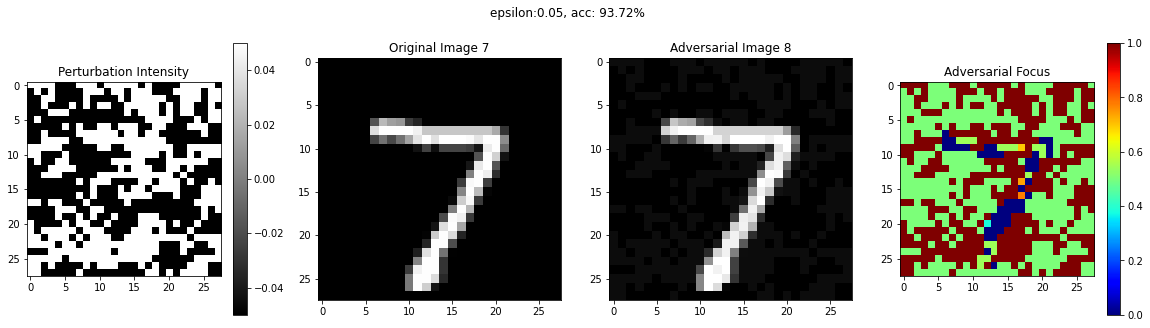

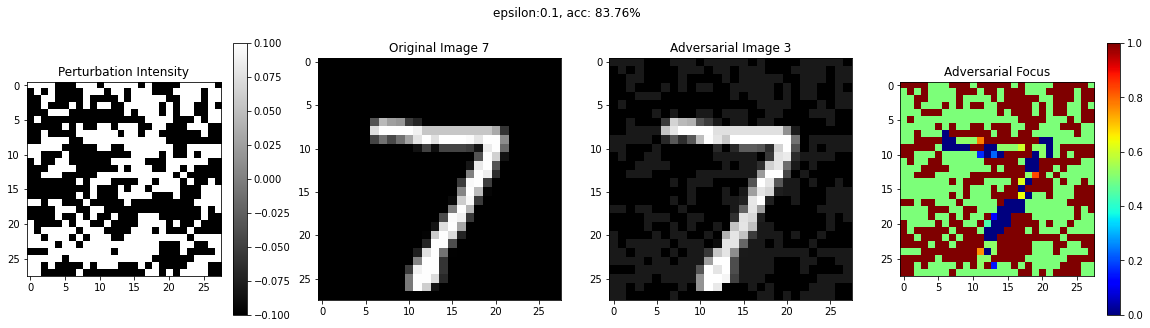

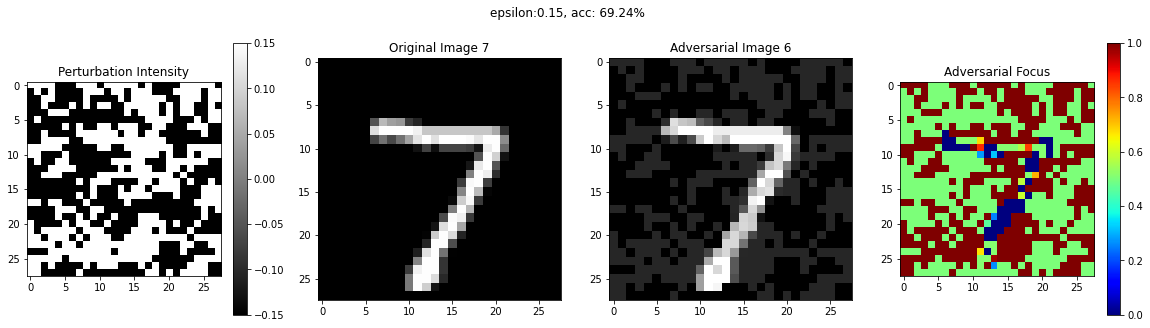

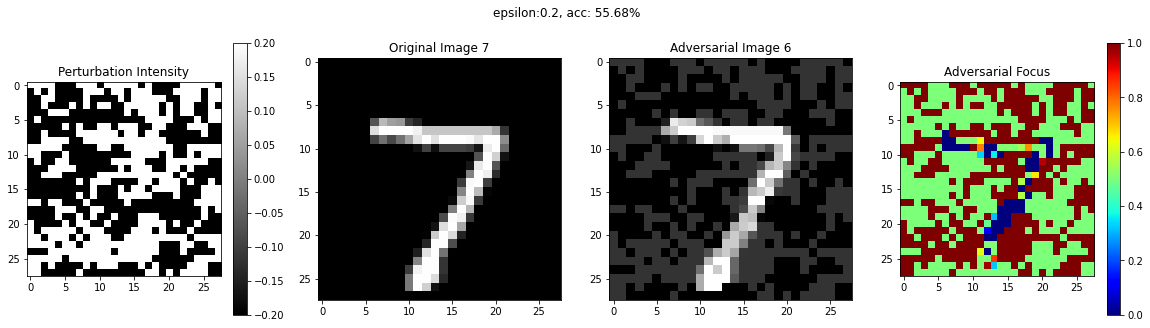

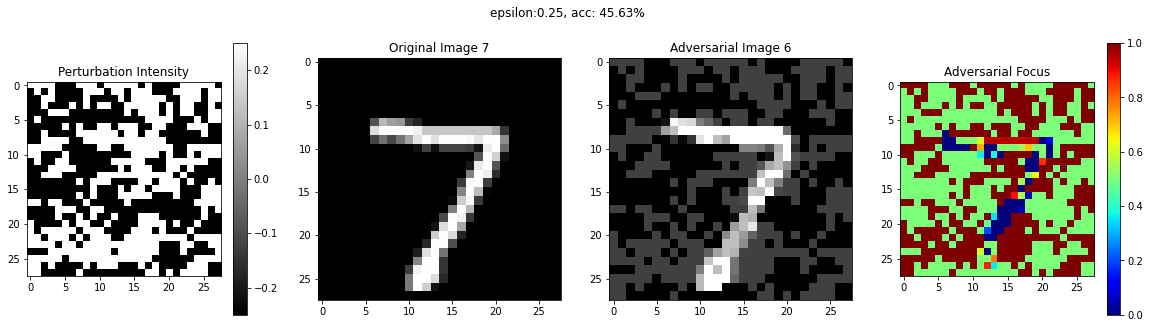

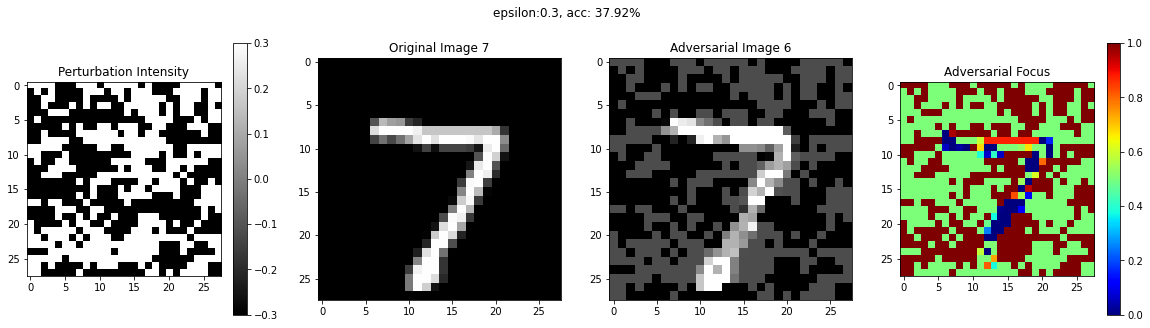

In [61]:
for e, e_value in enumerate(epsilons):
    if e == 0: continue
    
    plt.figure(figsize = (20, 5))
    plt.suptitle(f"epsilon:{e_value}, acc: {np.round(accuracies_B[e] * 100, 4)}%")
    i = 0

    plt.subplot(1,4,1)
    p = perturbations_B[e][i][0][0].squeeze().detach().cpu().numpy()
    plt.imshow(p, cmap="gray")
    plt.title(f"Perturbation Intensity")
    plt.colorbar()

    plt.subplot(1,4,2)
    original_img = examples_B[e][i][3][0][0].squeeze().detach().cpu().numpy()
    plt.imshow(original_img, cmap="gray")
    plt.title(f"Original Image {examples_B[0][i][0]}")


    plt.subplot(1,4,3)
    adv_img = examples_B[e][i][2][0]
    plt.imshow(adv_img, cmap="gray")
    plt.title(f"Adversarial Image {examples_B[e][i][1]}")

    plt.subplot(1,4, 4)
    diff = adv_img - original_img
    # MinMax Scaling [0,1]
    diff = (diff - diff.min()) / (diff.max() - diff.min())
    plt.imshow(diff, cmap='jet')
    plt.colorbar()
    plt.title("Adversarial Focus")
    plt.show();

# Adversarial Training

In [3]:
import copy 

def get_fgsm_samples( model_ref, device, data, targets, epsilon ):

    model = copy.deepcopy(model_ref)

    # Loop over all examples in test set

    # Send the data and label to the device
    data, targets = data.to(device), targets.to(device)

    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True

    # Forward pass the data through the model
    output = model(data)
    init_preds = output.max(1, keepdim=True)[1] # get the index of the max log-probability

    # Calculate the loss
    loss = F.nll_loss(output, targets)

    # Zero all existing gradients
    model.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect datagrad
    data_grad = data.grad.data

    # Call FGSM Attack
    perturbed_data, perturbation = fgsm_attack(data, epsilon, data_grad)

    return perturbed_data

In [18]:
import importlib
import sys
importlib.reload(sys.modules['attacks'])
from attacks import fgsm_attack

epsilons = [0, .05, .1, .15, .2, .25, .3]
model_C = get_resnet18_MNIST().cuda()
criterion_C = nn.CrossEntropyLoss()
optimizer_C = optim.Adam(model_C.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    total_batch = len(mnist_train) // batch_size
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        X, perturbations = get_fgsm_samples(model_C, device, X, Y, 0.05)

        outputs = model_C(X)
        loss = criterion_C(outputs, Y)
        optimizer_C.zero_grad()
        loss.backward()
        optimizer_C.step()

    print('Epoch [%d/%d], Loss: %.4f'
        %(epoch+1, num_epochs, loss.item()))

Epoch [1/10], Loss: 0.2229
Epoch [2/10], Loss: 0.1720
Epoch [3/10], Loss: 0.1731
Epoch [4/10], Loss: 0.1419
Epoch [5/10], Loss: 0.1398
Epoch [6/10], Loss: 0.1396
Epoch [7/10], Loss: 0.1355
Epoch [8/10], Loss: 0.1323
Epoch [9/10], Loss: 0.1418
Epoch [10/10], Loss: 0.1410


In [131]:
import importlib
import sys
importlib.reload(sys.modules['attacks'])
from attacks import test_robustness

# eps = 0 means no attack
epsilons = [0, .05, 0.1]

# accuracies of each eps test
accuracies_C = []

# resulting adversarial examples
examples_C = []

# generated perturbations
perturbations_C = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex, adv_per = test_robustness(model_C, device, test_loader, eps)
    accuracies_C.append(acc)
    examples_C.append(ex)
    perturbations_C.append(adv_per)